In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import os
import joblib

pd.set_option('display.max_columns', None)

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from pyspark import SparkConf, SparkContext

In [4]:
conf = SparkConf()
conf.set("spark.executor.memory", "3g")
conf.set("spark.executor.cores", "1")
conf.set("spark.executor.instances", "12")

In [5]:
sc = SparkContext(conf=conf)

23/09/30 14:04:12 WARN Utils: Your hostname, Antons-iMac.local resolves to a loopback address: 127.0.0.1; using 192.168.2.200 instead (on interface en0)
23/09/30 14:04:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/30 14:04:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
spark = SparkSession.builder.appName('AcidSoils').getOrCreate()

In [ ]:
disk_path = "/Volumes/hasuriski 1/LAYERS_15"

In [216]:
COLUMNS = [
    "elevation", 
    "aspect", 
    "aem_imag", 
    "aem_real", 
    "landsat_0", 
    "landsat_1", 
    "landsat_2", 
    "NDVI", 
    "TPI", 
    "TWI", 
    "TRI",
]

## Load points

In [7]:
source = gpd.read_file("../local_data/GTK_ASsoil_obs.csv")
geom = gpd.points_from_xy(source.POINT_X.astype("float"), source.POINT_Y.astype("float"))
points = gpd.GeoDataFrame(source.CLASS, crs="EPSG:3067", geometry=geom).to_crs("WGS84")
points["x"] = points.geometry.x
points["y"] = points.geometry.y
del points["geometry"]
points["point_id"] = points.index
points.head(4)

,CLASS,x,y,point_id
0,ASS,25.768938,64.777988,0
1,ASS,25.776304,64.793496,1
2,ASS,25.784691,64.786808,2
3,ASS,25.315115,64.988732,3


In [19]:
df_points = spark.createDataFrame(points).repartition(12)
df_points.show(4, truncate=False)

/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+-----+------------------+-----------------+--------+
|CLASS|x                 |y                |point_id|
+-----+------------------+-----------------+--------+
|ASS  |23.48789333423371 |63.85144666782518|574     |
|ASS  |23.39232833237554 |63.90848500194046|603     |
|ASS  |25.840422066548204|65.44494636615953|140     |
|ASS  |25.309868332882065|64.61212333296837|78      |
+-----+------------------+-----------------+--------+
only showing top 4 rows



In [20]:
df_points.groupby('CLASS').count().show()

+-------+-----+
|  CLASS|count|
+-------+-----+
|    ASS| 3490|
|non-ASS| 2334|
+-------+-----+



# Load pixels

## Get tile coordinates

In [21]:
# use Papermill to run this

ZOOM = 15

In [22]:
TILE_SIZE = 256

In [23]:
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_pixel(lon, lat, zoom=ZOOM):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(px), int(py)]
    
    
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_tile(lon, lat, zoom=ZOOM):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(zoom), int(tx), int(ty)]

In [24]:
df_tiles = (
    df_points
    .withColumn("pixel", project_pixel(df_points.x, df_points.y))
    .withColumn("tile", project_tile(df_points.x, df_points.y))
    .withColumn("pixel_coord", F.array(F.col("pixel")[0], F.col("pixel")[1], F.col("point_id")))
    .withColumn("class", (F.col("CLASS") == "ASS").astype("int"))
)

In [25]:
df_tiles.show(4)

+-----+------------------+-----------------+--------+----------+-----------------+---------------+
|class|                 x|                y|point_id|     pixel|             tile|    pixel_coord|
+-----+------------------+-----------------+--------+----------+-----------------+---------------+
|    1| 23.48789333423371|63.85144666782518|     574|[235, 198]|[15, 18521, 8769]|[235, 198, 574]|
|    1| 23.39232833237554|63.90848500194046|     603| [56, 251]|[15, 18513, 8757]| [56, 251, 603]|
|    1|25.840422066548204|65.44494636615953|     140| [13, 234]|[15, 18736, 8430]| [13, 234, 140]|
|    1|25.309868332882065|64.61212333296837|      78|[194, 126]|[15, 18687, 8610]| [194, 126, 78]|
+-----+------------------+-----------------+--------+----------+-----------------+---------------+
only showing top 4 rows



## Load tile pixels

In [26]:
df_tile_coords = (
    df_tiles
    .groupby("tile")
    .agg(F.collect_list("pixel_coord").alias("pixel_coord_list"))
)

In [27]:
@F.udf(returnType=T.ArrayType(T.ArrayType(T.LongType())))
def load_image_data(tile, pixel_coord, tiles):
    """
    tiles: folder with tiles
    """
    (z, tx, ty) = tile
    fname = tiles.format(z=z, x=tx, y=ty)
    
    try:
        im = Image.open(fname)
        arr_img = np.array(im)
    except FileNotFoundError:
        # print(tiles, [pid for _,_,pid in pixel_coord])
        return [(0, 0, 0, pid) for _,_,pid in pixel_coord]

    data = []
    for i, j, pid in pixel_coord:
        pixel = arr_img[i, j]
        data.append([
            int(pixel[0]),
            int(pixel[1]),
            int(0 if len(pixel) < 3 else pixel[2]),
            pid
        ])
        
    return data

In [28]:
def get_layer_data(tiles_path, prefix, gray=True):
    png_path = tiles_path + "/{z}/{x}/{y}.png"
    df_data = (
        df_tile_coords
        .withColumn(
            "loaded_data", 
            load_image_data(F.col("tile"), F.col("pixel_coord_list"), F.lit(png_path))
        )
        .select(F.explode("loaded_data").alias("data"))
    )
    if gray:
        return df_data.select(
            F.col("data")[3].alias("point_id"),
            F.col("data")[0].alias(f"{prefix}"),
        )
    else:
        return df_data.select(
            F.col("data")[3].alias("point_id"),
            F.col("data")[0].alias(f"{prefix}_0"),
            F.col("data")[1].alias(f"{prefix}_1"),
            F.col("data")[2].alias(f"{prefix}_2"),
        )

full data

```
df_data = (
    df_tiles
    .join(get_layer_data(f"{disk_path}/elev_10m", "elevation"), on="point_id")
    .join(get_layer_data(f"{disk_path}/elev_10m_aspect", "aspect"), on="point_id")
    .join(get_layer_data(f"{disk_path}/elev_10m_hillshade", "hillshade"), on="point_id")
    .join(get_layer_data(f"{disk_path}/elev_10m_slope", "slope"), on="point_id")
    .join(get_layer_data(f"{disk_path}/landsat", "landsat", gray=False), on="point_id")
    .join(get_layer_data(f"{disk_path}/NDVI_max", "NDVI"), on="point_id")
    .join(get_layer_data(f"{disk_path}/TPI", "TPI"), on="point_id")
    .join(get_layer_data(f"{disk_path}/TRI", "TRI"), on="point_id")
    .join(get_layer_data(f"{disk_path}/TWI", "TWI"), on="point_id")
    .join(get_layer_data(f"{disk_path}/aem_real_component", "aem_real"), on="point_id")
    .join(get_layer_data(f"{disk_path}/aem_apparent_resistivity", "aem_resist"), on="point_id")
    .join(get_layer_data(f"{disk_path}/aem_imaginary_component", "aem_imag"), on="point_id")
    .join(
        get_layer_data(f"{disk_path}/corine_land_cover", "corine").select(
            "point_id",
            *[(F.col("corine") == i).astype("int").alias(f"corine_{i}") for i in range(1, 50)],
        ), 
        on="point_id"
    )
    .join(
        get_layer_data(f"{disk_path}/bedrock", "bedrock").select(
            "point_id",
            *[(F.col("bedrock") == i).astype("int").alias(f"bedrock_{i}") for i in range(1, 42)],
        ), 
        on="point_id"
    )
)

df_data.toPandas().head(3)
```

reduced valuable data

In [215]:
# ['elevation', 'aem_imag', 'landsat_1', 'landsat_0', 'landsat_2', 'aem_real', 'aspect', 'NDVI', 'TPI', 'TWI', 'TRI', 'aem_resist', 'hillshade', 'slope']

df_data = (
    df_tiles
    .join(get_layer_data(f"{disk_path}/elev_10m", "elevation"), on="point_id")
    .join(get_layer_data(f"{disk_path}/elev_10m_aspect", "aspect"), on="point_id")

    .join(get_layer_data(f"{disk_path}/aem_imaginary_component", "aem_imag"), on="point_id")
    .join(get_layer_data(f"{disk_path}/aem_real_component", "aem_real"), on="point_id")

    .join(get_layer_data(f"{disk_path}/landsat", "landsat", gray=False), on="point_id")

    .join(get_layer_data(f"{disk_path}/NDVI_max", "NDVI"), on="point_id")
    .join(get_layer_data(f"{disk_path}/TPI", "TPI"), on="point_id")
    .join(get_layer_data(f"{disk_path}/TWI", "TWI"), on="point_id")
    .join(get_layer_data(f"{disk_path}/TRI", "TRI"), on="point_id")
    .cache()
)

df_data.toPandas().head(3)

,point_id,class,x,y,pixel,tile,pixel_coord,elevation,aspect,aem_imag,aem_real,landsat_0,landsat_1,landsat_2,NDVI,TPI,TWI,TRI
0,2446,1,22.867336,63.879747,"[111, 237]","[15, 18465, 8763]","[111, 237, 2446]",254,173,230,233,145,99,154,177,127,0,253
1,2450,1,22.884331,63.798067,"[251, 201]","[15, 18466, 8780]","[251, 201, 2450]",251,62,240,238,95,98,74,172,107,0,222
2,2449,1,22.892701,63.826955,"[190, 212]","[15, 18467, 8774]","[190, 212, 2449]",251,205,254,255,114,222,114,185,141,0,135


# Random Forest

## Format data

In [217]:
pd_data = (
    df_data
    .select(
        "class",
        *COLUMNS
    )
    .toPandas()
)

pd_data.head(3)

,class,elevation,aspect,aem_imag,aem_real,landsat_0,landsat_1,landsat_2,NDVI,TPI,TWI,TRI
0,1,254,173,230,233,145,99,154,177,127,0,253
1,1,251,62,240,238,95,98,74,172,107,0,222
2,1,251,205,254,255,114,222,114,185,141,0,135


In [218]:
pd.set_option('display.max_columns', None)

In [219]:
pd_data.head(10)

,class,elevation,aspect,aem_imag,aem_real,landsat_0,landsat_1,landsat_2,NDVI,TPI,TWI,TRI
0,1,254,173,230,233,145,99,154,177,127,0,253
1,1,251,62,240,238,95,98,74,172,107,0,222
2,1,251,205,254,255,114,222,114,185,141,0,135
3,1,254,128,205,137,99,178,95,168,122,0,246
4,0,251,72,255,254,101,179,103,166,126,0,145
5,1,249,195,122,206,224,203,158,181,126,0,231
6,0,255,143,254,253,159,217,100,158,146,164,222
7,1,250,119,119,207,2,50,79,166,132,148,249
8,1,246,250,255,251,96,135,76,162,131,189,223
9,0,252,232,255,254,52,207,99,120,112,196,217


In [220]:
pd_data["class"].value_counts()

class
1    3490
0    2334
Name: count, dtype: int64

In [221]:
X = pd_data.iloc[:, 1:]
Y = pd_data.iloc[:, 0]

In [247]:
np.savez("../local_data/xy.npz", X=X, Y=Y)

### Normalize and save data for ELM

In [529]:
pd_data.mean()

class          0.599245
elevation    202.076236
aspect       127.737809
aem_imag     126.550996
aem_real     163.027473
landsat_0    137.324863
landsat_1    151.554430
landsat_2    128.735920
NDVI         168.555632
TPI          126.166037
TWI          177.148695
TRI          220.419986
dtype: float64

In [530]:
X = np.load("../local_data/xy.npz")["X"].astype("float32")
X -= 128

X[:, 10] = np.log(256 - X[:,10])

In [531]:
mX = np.array([74, 0, -1, 35, 9, 23, 0, 40, -2, 50, 5])
sX = np.array([40, 70, 80, 60, 75, 65, 50, 20, 20, 35, 0.2])
X.mean(0) - mX

array([ 0.07623291, -0.26219094, -0.44900417,  0.02747345,  0.32486248,
        0.55443001,  0.73592031,  0.55563354,  0.16603708, -0.8513031 ,
        0.07521391])

In [532]:
X = (X - mX) / sX
X = np.clip(X, -5, 5)

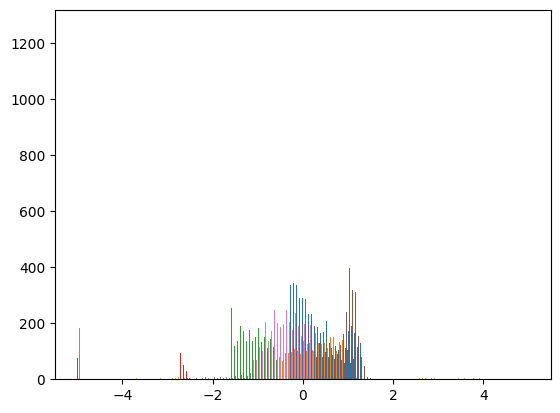

In [533]:
plt.hist(X, 150)
plt.show()

In [538]:
np.save("../local_data/X.npy", X.astype("float32"))
np.save("../local_data/Y.npy", Y[:, None].astype("float32"))

In [528]:
L = 150 

W = np.random.randn(11, L) / 11**0.5
bias = np.random.randn(L)

np.save(f"../local_data/W_{L}.npy", W.astype("float32"))
np.save(f"../local_data/bias_{L}.npy", bias.astype("float32"))

### Test ELM performance with these params

In [522]:
H = np.tanh(X@W + bias)

In [523]:
B = np.linalg.solve(H.T@H, H.T@Y)

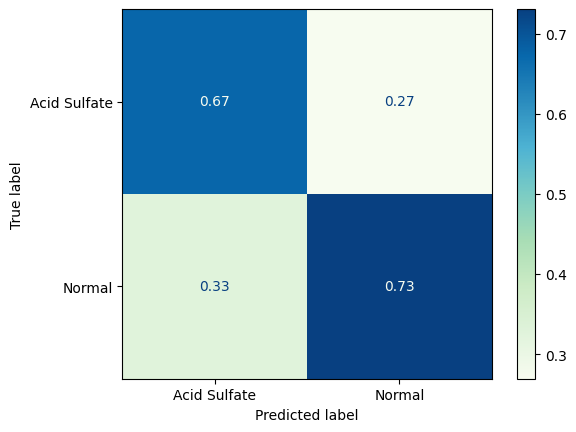

In [524]:
ConfusionMatrixDisplay(
    confusion_matrix(Y, (H@B > 0.5), normalize="pred"),
    display_labels=["Acid Sulfate", "Normal"],
).plot(cmap="GnBu")

In [525]:
from skelm import ELMClassifier

In [526]:
Yh = ELMClassifier(n_neurons=150).fit(X, Y).predict(X)

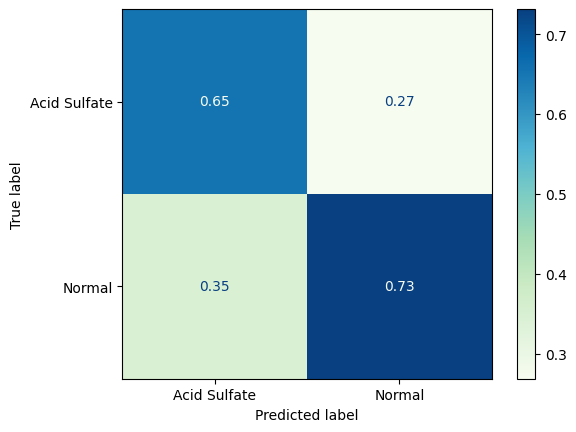

In [527]:
ConfusionMatrixDisplay(
    confusion_matrix(Y, Yh, normalize="pred"),
    display_labels=["Acid Sulfate", "Normal"],
).plot(cmap="GnBu")

### Test what images look like

In [565]:
X1 = np.load("/Volumes/hasuriski 1/LAYERS_15/combined_data/12/2299/1113.npy")

In [566]:
H1 = np.tanh(X1@W + bias)
Y1 = H1 @ B

In [567]:
Y1 = Y1.reshape(256, 256)

In [568]:
Y1

array([[-2.08637508, -1.92948172, -0.2865768 , ..., -0.91819386,
        -1.7031445 , -1.55721887],
       [-2.07499515, -1.43328204, -0.95581694, ..., -0.09703709,
        -0.68857724, -0.66243363],
       [-1.3480563 , -1.06301904, -0.98864139, ..., -0.15006351,
         0.00695713, -1.4274998 ],
       ...,
       [-1.27246305, -1.50064677, -1.17066298, ..., -1.65673773,
        -1.05032469, -1.37323355],
       [-1.32000954, -1.01567233, -1.40640982, ..., -1.35003936,
        -1.25307448, -1.9935131 ],
       [-0.90627024, -0.86484432, -1.61798964, ..., -1.42983861,
        -0.84786816, -1.85296538]])

In [569]:
cm = plt.get_cmap('terrain_r')

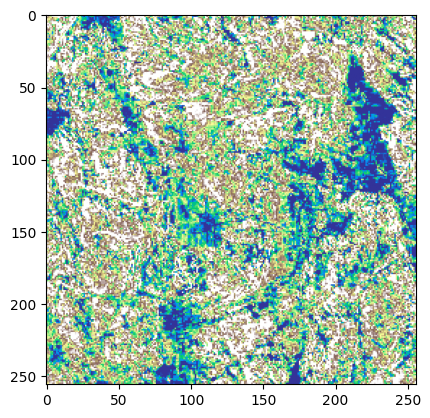

In [570]:
plt.imshow(cm(Y1/1.7 + 1))

## Train random forest

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier

In [252]:
X, Y = [
    np.load("../local_data/xy.npz")[key] 
    for key in ("X", "Y")
]

In [253]:
Xt, Xs, Yt, Ys = train_test_split(X, Y, random_state=66)

In [254]:
scaler = RobustScaler().fit(Xt)
Xt = scaler.transform(Xt)
Xs = scaler.transform(Xs)

In [255]:
rfc = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,
    n_jobs=8, 
    random_state=0
)
rfc.fit(Xt, Yt)

RandomForestClassifier(max_depth=15, n_jobs=8, random_state=0)

In [256]:
rfc.score(Xs, Ys)

0.7376373626373627

In [257]:
joblib.dump((scaler, rfc), "rfc.joblib")

['rfc.joblib']

## Find useful features

In [190]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [198]:
rfc2 = RandomForestClassifier(
    n_estimators=300, 
    max_depth=25,
    max_features=5,
    n_jobs=8, 
    random_state=0
)
rfc2.fit(Xt, Yt)

RandomForestClassifier(max_depth=25, max_features=5, n_estimators=300, n_jobs=8,
                       random_state=0)

In [199]:
r2_score(Ys, rfc2.predict_proba(Xs)[:, 1])

0.2395032886007411

In [200]:
roc_auc_score(Ys, rfc2.predict_proba(Xs)[:, 1])

0.7835002356151527

In [201]:
feats = pd.DataFrame([
        list(pd_data.columns[1:]),
        rfc2.feature_importances_,
    ]).T

feats.columns = ["feature", "importance"]

feats = feats.sort_values(by="importance", ascending=False).reset_index(drop=True)

(0.0, 0.2)

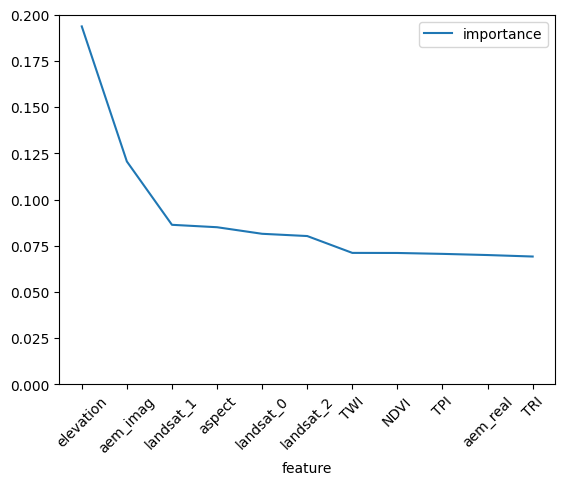

In [202]:
sns.lineplot(
    feats[:15].set_index("feature")
)
_ = plt.xticks(rotation=45)
plt.ylim([0, 0.2])

In [203]:
feats[:14].feature.values

array(['elevation', 'aem_imag', 'landsat_1', 'aspect', 'landsat_0',
       'landsat_2', 'TWI', 'NDVI', 'TPI', 'aem_real', 'TRI'], dtype=object)

## Model metrics

In [458]:
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
import seaborn as sn

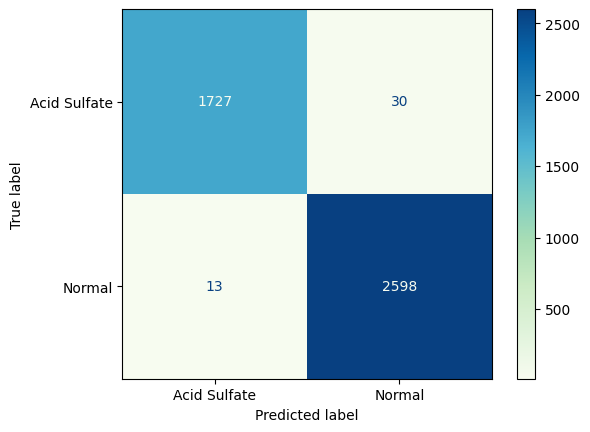

In [459]:
ConfusionMatrixDisplay(
    confusion_matrix(Yt, rfc.predict(Xt)),
    display_labels=["Acid Sulfate", "Normal"],
).plot(cmap="GnBu")

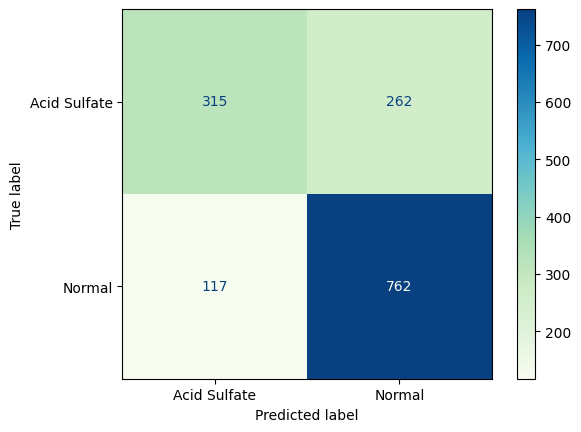

In [48]:
ConfusionMatrixDisplay(
    confusion_matrix(Ys, rfc.predict(Xs)),
    display_labels=["Acid Sulfate", "Normal"]
).plot(cmap="GnBu")

In [49]:
r2_score(Ys, rfc.predict_proba(Xs)[:, 1])

0.23769446939535277

In [50]:
roc_auc_score(Ys, rfc.predict_proba(Xs)[:, 1])

0.7873528884051713

/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akusok/Library/Caches/py

<Axes: >

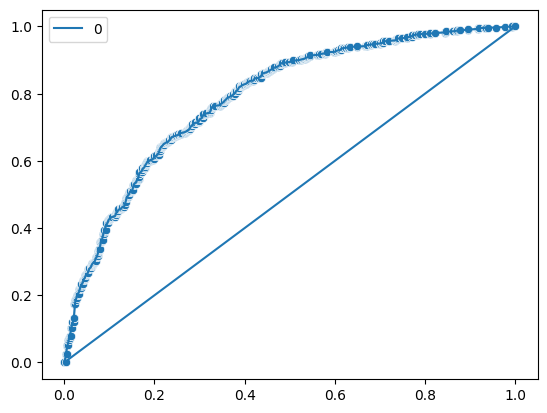

In [51]:
fpr, tpr, thresholds = roc_curve(Ys, rfc.predict_proba(Xs)[:, 1])
sns.scatterplot(x=fpr, y=tpr)
sns.lineplot(x=fpr, y=tpr)
sns.lineplot([[0,1]])

## Search for a good model

In [52]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV
from scipy.stats import distributions

In [54]:
param_distributions = {
    "n_estimators": 10 * np.arange(10, 51),
    "max_depth": [13, ], #[8, 9, 10, 11, 12, 13, 14],
    
    # "criterion": ["entropy", "log_loss"],
    # "min_samples_split": distributions.randint(2, 10),
    # "min_samples_leaf": distributions.randint(1, 10),
    # "max_features": ["sqrt", "log2", 999],
    
}

rcv = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=2),
    param_distributions,
    n_iter=1000,
    n_jobs=5,
    refit=False,
    cv=10,
    verbose=0
)

In [55]:
result = rcv.fit(X, Y)
cv = pd.DataFrame(result.cv_results_)

/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 41 is smaller than n_iter=1000. Running 41 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/akusok/Library

<Axes: xlabel='param_n_estimators'>

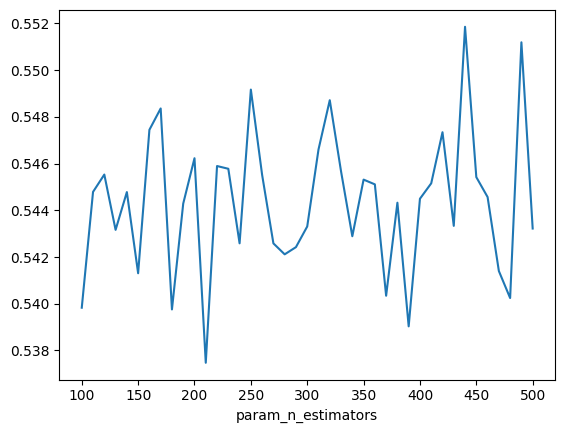

In [61]:
sns.lineplot(
    data=cv.groupby("param_n_estimators")["mean_test_score"].mean() - 2*cv.groupby("param_n_estimators")["std_test_score"].mean()
)

<Axes: xlabel='param_n_estimators', ylabel='param_max_depth'>

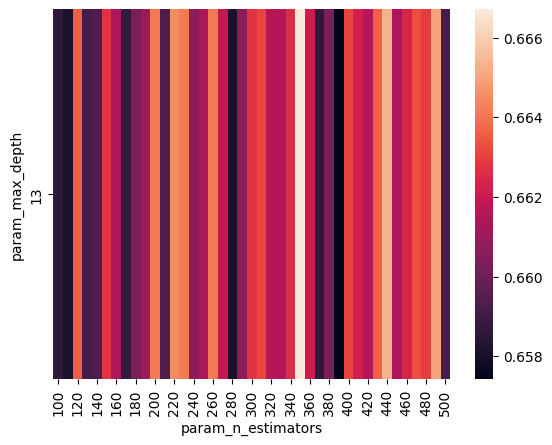

In [62]:
sns.heatmap(
    pd.pivot_table(cv, "mean_test_score", "param_max_depth", "param_n_estimators")
)

In [63]:
result = rcv.fit(X, Y)

/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 41 is smaller than n_iter=1000. Running 41 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
cv = pd.DataFrame(result.cv_results_)

In [ ]:
sns.heatmap(
    pd.pivot_table(cv, "mean_test_score", "param_n_estimators", "param_max_depth")
)

## Compare to old dataset without acidity

In [46]:
from sklearn.metrics import r2_score, roc_auc_score, roc_curve

In [47]:
fname = "PO_5layers_Virolahti.csv"

In [48]:
pd_virolahti = (
    pd.read_csv(fname, index_col=0)
    .drop("min-field-pH", axis=1)
    .drop("min-incubation-pH", axis=1)
)

pd_virolahti.head(5)

,X,Y,DEM,slope,quaternary,aem_real,aem_im,AcidSulfateSoil
0,552227.22,6726933.56,21.629000,2.241054,11.0,59.017155,841.359253,0
1,550204.23,6728179.70,28.336000,2.120679,2.0,-58.367680,326.269165,0
2,540067.74,6727800.89,28.221001,3.822676,2.0,34.048119,343.239136,0
3,539820.46,6726312.26,13.398000,0.459955,7.0,376.158508,1497.486938,0
4,538845.04,6728534.79,30.162001,0.912897,2.0,6.915876,399.327026,0


In [49]:
vX = pd_virolahti.iloc[:, :-1].values
vY = pd_virolahti.iloc[:, -1].values

In [62]:
vX = RobustScaler().fit_transform(vX)

In [63]:
vXt, vXs, vYt, vYs = train_test_split(vX, vY, random_state=66)

In [77]:
vrfc = RandomForestClassifier(
    n_estimators=200, 
    max_depth=5,
    n_jobs=8, 
)
vrfc.fit(vXt, vYt)

RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=8)

In [78]:
vrfc.score(vXs, vYs)

0.6708860759493671

In [79]:
r2_score(vYs, vrfc.predict_proba(vXs)[:, 1])

0.03472489910923582

In [80]:
roc_auc_score(vYs, vrfc.predict_proba(vXs)[:, 1])

0.6524216524216524

<Axes: >

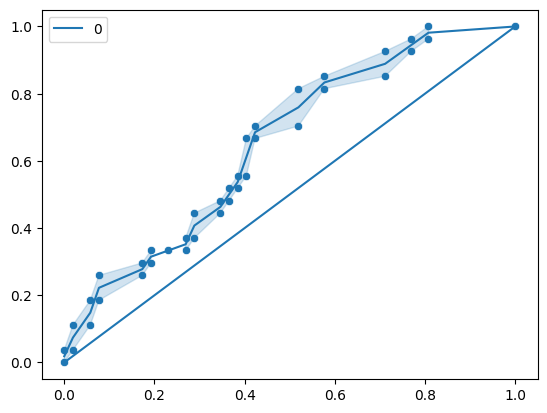

In [81]:
fpr, tpr, thresholds = roc_curve(vYs, vrfc.predict_proba(vXs)[:, 1])
sns.scatterplot(x=fpr, y=tpr)
sns.lineplot(x=fpr, y=tpr)
sns.lineplot([[0,1]])

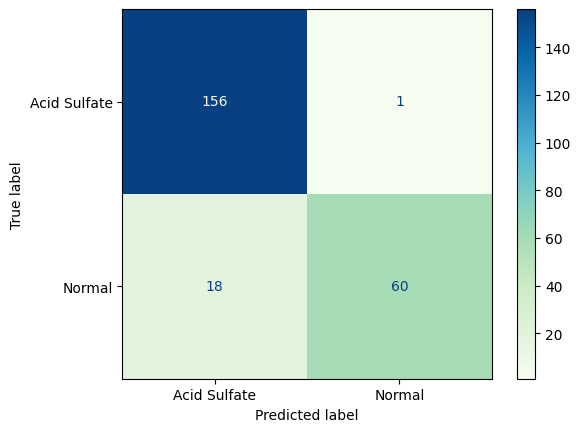

In [82]:
ConfusionMatrixDisplay(
    confusion_matrix(vYt, vrfc.predict(vXt)),
    display_labels=["Acid Sulfate", "Normal"],
).plot(cmap="GnBu")

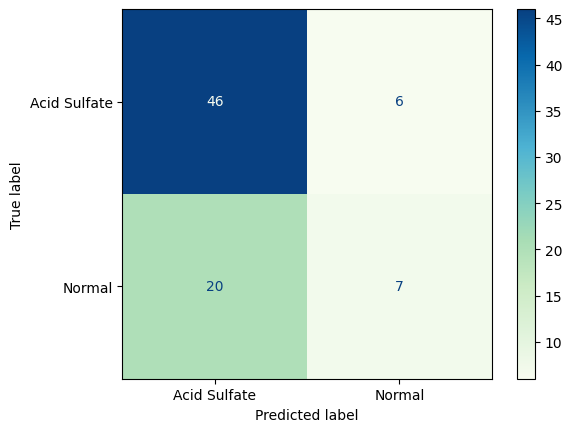

In [83]:
ConfusionMatrixDisplay(
    confusion_matrix(vYs, vrfc.predict(vXs)),
    display_labels=["Acid Sulfate", "Normal"],
).plot(cmap="GnBu")

# Predict map

In [3]:
with open("tiles_analysis.txt", "r") as f:
    tiles = [line[9:-1] for line in f.readlines()]
    
scaler, rfc = joblib.load("rfc.joblib")
rfc.n_jobs = None

In [4]:
layers = [
    ("elevation", 1, "/Users/akusok/wrkdir/TILES/elevation_10m"),
    ("aspect", 1, "/Users/akusok/wrkdir/TILES/elev_10m_aspect"),
    ("hillshade", 1, "/Users/akusok/wrkdir/TILES/elev_10m_hillshade"),
    ("slope", 1, "/Users/akusok/wrkdir/TILES/elev_10m_slope"),
    ("landsat", 3, "/Users/akusok/wrkdir/TILES/landsat"),
    ("NDVI", 1, "/Users/akusok/wrkdir/TILES/NDVI_max"),
    ("TPI", 1, "/Users/akusok/wrkdir/TILES/TPI"),
    ("TRI", 1, "/Users/akusok/wrkdir/TILES/TRI"),
    ("TWI", 1, "/Users/akusok/wrkdir/TILES/TWI"),
    ("aem_real", 1, "/Users/akusok/wrkdir/TILES/TILES_aemagnetic_real_component"),
    ("aem_resist", 1, "/Users/akusok/wrkdir/TILES/TILES_aeroelectromagnetic_apparent_resistivity"),
    ("aem_imag", 1, "/Users/akusok/wrkdir/TILES/TILES_aeroelectromagnetic_imaginary_component"),
    ("corine", 1, "/Users/akusok/wrkdir/TILES/corine_land_cover"),
    ("bedrock", 1, "/Users/akusok/wrkdir/TILES/bedrock"),
]

In [5]:
def get_img(tile, cm):
    
    data = {}
    for layer, channels, fimg in layers:
        fimg += tile
        try:
            x_img = np.array(Image.open(fimg))
        except:
            return None

        if layer == "corine":
            x = x_img[:, :, 0].ravel()
            for i in range(1, 50):
                data[f"{layer}_{i}"] = (x == i).astype(int)

        elif layer == "bedrock":
            x = x_img[:, :, 0].ravel()
            for i in range(1, 42):
                data[f"{layer}_{i}"] = (x == i).astype(int)

        elif channels == 1:
            data[layer] = x_img[:, :, 0].ravel()

        else:
            for c in range(channels):
                data[f"{layer}_{c}"] = x_img[:, :, c].ravel()

    Xs_raw = pd.DataFrame(data)
    water = (Xs_raw.corine_47 == 1) | (Xs_raw.corine_48 == 1) | (Xs_raw.corine_49 == 1)
    
    Xs = scaler.transform(Xs_raw)
    ys = rfc.predict_log_proba(Xs)[:, 1]
    ys = ys/1.7 + 1
    ys[water] = 0
    
    colored_image = cm(ys)
    img = Image.fromarray((colored_image.reshape(256, 256, -1) * 255).astype(np.uint8))
    return img

## Play with water

In [ ]:
tile = "/9/288/148.png"

data = {}
for layer, channels, fimg in layers:
    fimg += tile
    x_img = np.array(Image.open(fimg))

    if layer == "corine":
        x = x_img[:, :, 0].ravel()
        for i in range(1, 50):
            data[f"{layer}_{i}"] = (x == i).astype(int)

    elif layer == "bedrock":
        x = x_img[:, :, 0].ravel()
        for i in range(1, 42):
            data[f"{layer}_{i}"] = (x == i).astype(int)

    elif channels == 1:
        data[layer] = x_img[:, :, 0].ravel()

    else:
        for c in range(channels):
            data[f"{layer}_{c}"] = x_img[:, :, c].ravel()

Xs_raw = pd.DataFrame(data)

In [74]:
water = (Xs_raw.corine_49 == 1)
water

0        False
1        False
2        False
3        False
4        False
         ...  
65531    False
65532    False
65533    False
65534    False
65535    False
Name: corine_49, Length: 65536, dtype: bool

In [75]:
Xs = scaler.transform(Xs_raw)

In [76]:
%time ys = rfc.predict_log_proba(Xs)[:, 1]

CPU times: user 2.53 s, sys: 83.3 ms, total: 2.61 s
Wall time: 417 ms


In [82]:
ys /= 1.7
ys[water] = -1
ys[::100] + 1

array([0.97402477, 0.        , 0.95828332, 0.98108972, 0.95967814,
       0.97089533, 0.        , 0.96209516, 0.97076146, 0.98615794,
       0.96880975, 0.9615096 , 0.96126644, 0.        , 0.96309454,
       0.98498229, 0.96652201, 0.94811168, 0.        , 0.9688301 ,
       0.96487986, 0.97378907, 0.96432244, 0.971817  , 0.97723568,
       0.96016004, 0.96994378, 0.97718383, 0.97011457, 0.97301612,
       0.97270337, 0.97336576, 0.98020873, 0.98457852, 0.97508482,
       0.96302685, 0.98554336, 0.97954655, 0.98580007, 0.97478464,
       0.96173362, 0.        , 0.96848535, 0.96399688, 0.98221634,
       0.96776614, 0.96393477, 0.97909562, 0.96007758, 0.97893282,
       0.        , 0.97019702, 0.9717476 , 0.96723863, 0.        ,
       0.96703356, 0.9799239 , 0.96234716, 0.97194191, 0.        ,
       0.9721598 , 0.96938815, 0.97050568, 0.95543451, 0.97121797,
       0.97742884, 0.97009884, 0.96216639, 0.95621436, 0.9651773 ,
       0.96200893, 0.96985938, 0.97734902, 0.        , 0.96284

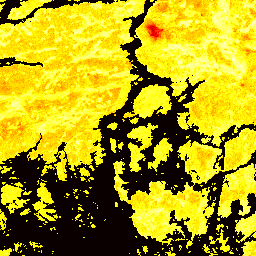

In [86]:
cm = plt.get_cmap('hot')

ys = rfc.predict_log_proba(Xs)[:, 1]
ys /= 1.7
ys[water] = -1
ys += 1

colored_image = cm(ys)
img = Image.fromarray((colored_image.reshape(256, 256, -1) * 255).astype(np.uint8))
img

## Play around with image display

In [ ]:
terrain_r
gist_ncar_r
coolwarm
cubehelix_r

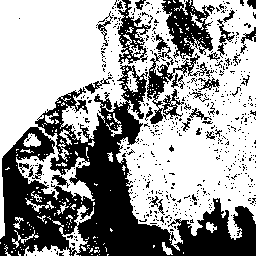

In [159]:
Image.fromarray(ys.astype("uint8").reshape(256, 256) * 255)

In [169]:
%time ys_proba = rfc.predict_proba(Xs)[:, 1]

CPU times: user 2.05 s, sys: 100 ms, total: 2.15 s
Wall time: 364 ms


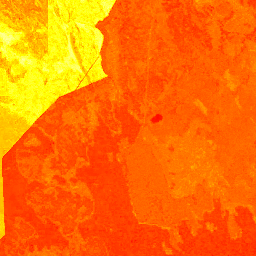

In [193]:
cm = plt.get_cmap('hot')

colored_image = cm(ys_proba)
Image.fromarray((colored_image.reshape(256, 256, -1) * 255).astype(np.uint8))

In [189]:
%time ys_logp = rfc.predict_log_proba(Xs)[:, 1]

CPU times: user 2.05 s, sys: 95.2 ms, total: 2.14 s
Wall time: 363 ms


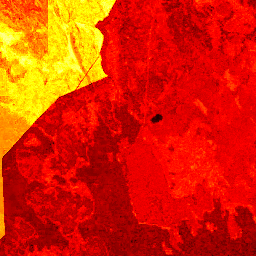

In [194]:
colored_image = cm(ys_logp + 1)
Image.fromarray((colored_image.reshape(256, 256, -1) * 255).astype(np.uint8))

## Save images

In [8]:
cm = plt.get_cmap('terrain_r')
dir_out = "/Users/akusok/wrkdir/predict_TILES/foo"

In [18]:
@F.udf
def foo(tile):
    print(".", end="")
    img_out = dir_out + tile
    img = get_img(tile, cm)
    if img is not None:
        os.makedirs(os.path.dirname(img_out), exist_ok=True)
        img.save(img_out)
    return "."

In [10]:
%load_ext line_profiler

In [17]:
%lprun -f rfc.predict_proba [foo(t) for t in tiles if int(t.split("/")[1]) == 8]

..................................................

Timer unit: 1e-09 s

Total time: 22.5434 s
File: /Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py
Function: predict_proba at line 838

Line #      Hits         Time  Per Hit   % Time  Line Contents
   838                                               def predict_proba(self, X):
   839                                                   """
   840                                                   Predict class probabilities for X.
   841                                           
   842                                                   The predicted class probabilities of an input sample are computed as
   843                                                   the mean predicted class probabilities of the trees in the forest.
   844                                                   The class probability of a single tree is the fraction of samples of
   845                                                   

In [20]:
%%time
pd_tiles = pd.DataFrame([t for t in tiles if int(t.split("/")[1]) < 9], columns=["tile",])
_ = spark.createDataFrame(pd_tiles).repartition(7).withColumn("_", foo(F.col("tile"))).collect()

/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
.Stage 2:============================================>              (3 + 1) / 4]...................................................................................

CPU times: user 352 ms, sys: 52.5 ms, total: 405 ms
Wall time: 29.2 s


In [25]:
%%time
pd_tiles = pd.DataFrame([t for t in tiles if int(t.split("/")[1]) == 9], columns=["tile",])
_ = spark.createDataFrame(pd_tiles).repartition(32).withColumn("_", foo(F.col("tile"))).collect()

/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
...age 14:======================================================> (31 + 1) / 32]...............................................................................

CPU times: user 367 ms, sys: 39.7 ms, total: 406 ms
Wall time: 23.7 s


In [9]:
%%time
pd_tiles = pd.DataFrame([t for t in tiles if int(t.split("/")[1]) == 9], columns=["tile",])
_ = spark.createDataFrame(pd_tiles).repartition(32).withColumn("_", foo(F.col("tile"))).collect()

/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
.Stage 5:=============================>                             (1 + 1) / 2]...............................................................................................................................................

CPU times: user 365 ms, sys: 42.3 ms, total: 407 ms
Wall time: 38.5 s


In [10]:
%%time
pd_tiles = pd.DataFrame([t for t in tiles if int(t.split("/")[1]) == 10], columns=["tile",])
_ = spark.createDataFrame(pd_tiles).repartition(32).withColumn("_", foo(F.col("tile"))).collect()

/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
.Stage 8:=============================>                             (1 + 1) / 2]..............................................................................................................................................................................................................................................................................................................................................................

CPU times: user 651 ms, sys: 109 ms, total: 761 ms
Wall time: 1min 42s


In [11]:
%%time
pd_tiles = pd.DataFrame([t for t in tiles if int(t.split("/")[1]) == 11], columns=["tile",])
_ = spark.createDataFrame(pd_tiles).repartition(32).withColumn("_", foo(F.col("tile"))).collect()

/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
.Stage 11:=============================>                            (1 + 1) / 2]..............................................................................................................................................................................................................................................................................................................................................................

CPU times: user 1.27 s, sys: 303 ms, total: 1.57 s
Wall time: 5min 25s


In [12]:
%%time
pd_tiles = pd.DataFrame([t for t in tiles if int(t.split("/")[1]) == 12], columns=["tile",])
_ = spark.createDataFrame(pd_tiles).repartition(32).withColumn("_", foo(F.col("tile"))).collect()

/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
........4:>                                                         (0 + 2) / 2]...........................ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/akusok/Li

In [13]:
%%time
pd_tiles = pd.DataFrame([t for t in tiles if int(t.split("/")[1]) == 13], columns=["tile",])
_ = spark.createDataFrame(pd_tiles).repartition(32).withColumn("_", foo(F.col("tile"))).collect()

....../Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
ERROR:root:KeyboardInterrupt while sending command.                 (0 + 2) / 2]
Traceback (most recent call last):
  File "/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python

In [ ]:
%%time
pd_tiles = pd.DataFrame([t for t in tiles if int(t.split("/")[1]) == 14], columns=["tile",])
_ = spark.createDataFrame(pd_tiles).repartition(32).withColumn("_", foo(F.col("tile"))).collect()

........../Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/akusok/Library/Caches/pypoetry/virtualenvs/poetry-spark-viFfSiCZ-py3.8/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
.......................................

In [ ]:
%%time
pd_tiles = pd.DataFrame([t for t in tiles if int(t.split("/")[1]) == 15], columns=["tile",])
_ = spark.createDataFrame(pd_tiles).repartition(32).withColumn("_", foo(F.col("tile"))).collect()